# KNN Assignment For Amazon Reviews

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:

# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)
print(display.shape)
display.head(2)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum() # Total sum

393063

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head() # Data cleaning :duplication

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
# Droping Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see that how much % of data still remains in final data
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [14]:
######### Preprocessing Reviews Text 
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_1)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_1).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
import warnings
warnings.filterwarnings("ignore")
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:14<00:00, 2156.77it/s]


In [23]:
final['CleanedText']=preprocessed_reviews
final['CleanedText'].head(2)

138695    remembered book childhood got kids good rememb...
138707    daughter loves really rosie books introduced r...
Name: CleanedText, dtype: object

In [24]:
data_for_brute=final.sample(100000)
print("For 100000 samples : \n" , data_for_brute['Score'].value_counts())
data_for_brute["Time"] = pd.to_datetime(data_for_brute["Time"], unit = "s")
data_brute = data_for_brute.sort_values(by = "Time")
print("data sample for brute")
print(data_brute.head())
data_for_kdtree=final.sample(20000)
print("For 20000 samples : \n" , data_for_kdtree['Score'].value_counts())

data_for_kdtree["Time"] = pd.to_datetime(data_for_kdtree["Time"], unit = "s")
data_kdtree = data_for_kdtree.sort_values(by = "Time")
print("data sample for kdtree")
print(data_kdtree.head())
# this is for 100k points
X=data_brute['CleanedText']
y=data_brute['Score']

X1=data_kdtree['CleanedText']
y1=data_kdtree['Score']

For 100000 samples : 
 1    84278
0    15722
Name: Score, dtype: int64
data sample for brute
            Id   ProductId          UserId       ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL   shari zychinski   
1146      1245  B00002Z754  A29Z5PI9BW2PU3            Robbie   
1145      1244  B00002Z754  A3B8RCEI0FXFI6         B G Chase   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   
138018  149790  B00004S1C6  A1IU7S4HCK1XK0    Joanna Daneman   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
138706                     0                       0      1 1999-10-08   
1146                       7                       7      1 2000-06-23   
1145                      10                      10      1 2000-06-29   
138017                    26                      28      1 2000-08-09   
138018                    25                      27      1 2001-02-22   

                                                  Summary  \
138706          

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)


In [26]:
#from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33) # this is random splitting
X1_train, X1_cv, y1_train, y1_cv = train_test_split(X1_train, y1_train, test_size=0.33) # random splitting
print(X1_train.shape, y1_train.shape)
print(X1_cv.shape, y1_cv.shape)
print(X1_test.shape, y1_test.shape)


(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix 
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
from sklearn import linear_model, datasets
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [29]:
print("**"*60)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

************************************************************************************************************************


# BOW

In [0]:
bow =CountVectorizer()

In [0]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow.fit_transform(X_train)
X_cv_bow = bow.transform(X_cv)
X_test_bow = bow.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(44890, 40479) (44890,)
(22110, 40479) (22110,)
(33000, 40479) (33000,)


### Applying KNN using brute on BOW

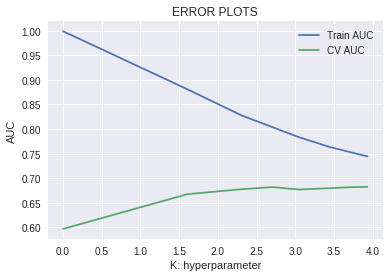

In [0]:

C = [1, 5, 10, 15, 21, 31, 41, 51]
from pylab import scatter
import pylab
import math
train_auc_brute = []
cv_auc_brute = []
for i in C:
    neigh_brute = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    model_brute = neigh_brute.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred_brute =  model_brute.predict_proba(X_train_bow)[:,1]
    y_cv_pred_brute =  model_brute.predict_proba(X_cv_bow)[:,1]
    train_auc_brute.append(roc_auc_score(y_train,y_train_pred_brute))
    cv_auc_brute.append(roc_auc_score(y_cv, y_cv_pred_brute))
    

plt.plot(np.log(C), train_auc_brute, label='Train AUC')
plt.plot(np.log(C), cv_auc_brute, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_bow = C[cv_auc_brute.index(max(cv_auc_brute))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_bow)


The optimal number of cv value in C is 51.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_bow = KNeighborsClassifier(n_neighbors=optimal_alpha_bow)
# fitting the model
knn_optimal_bow.fit(X_train_bow, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

In [0]:
pred_bow=knn_optimal_bow.predict(X_test_bow)
pred_bow_train=knn_optimal_bow.predict(X_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_bow = roc_auc_score(y_test, pred_bow)
print('\nThe auc socre for value= %f is %f%%' % (optimal_alpha_bow, auc_bow))


The auc socre for value= 51.000000 is 0.537379%


[[  459  4763]
 [  365 27413]]
   


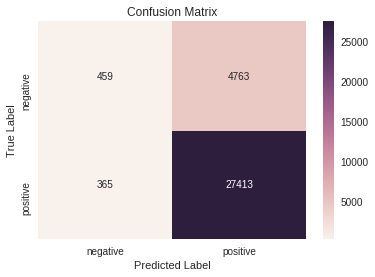

***************************************************************************
[[  624  6441]
 [  426 37399]]
   


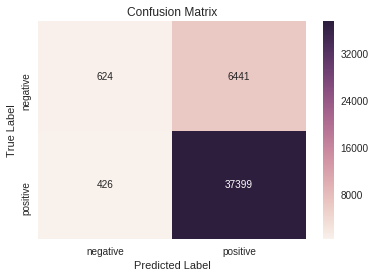

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
print(cm_bow)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_bow1 = confusion_matrix(y_train, pred_bow_train)
print(cm_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_bow1, index = class_label1, columns = class_label1)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

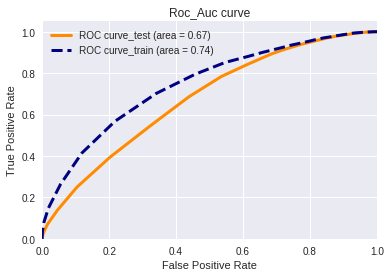

In [0]:
### Compute ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_predict =  knn_optimal_bow.predict_proba(X_test_bow)[:,1]
y_train_predict =  knn_optimal_bow.predict_proba(X_train_bow)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y_train,y_train_predict) 
fpr,tpr, _ = metrics.roc_curve(y_test,y_test_predict)

roc_auc = auc(fpr, tpr) 
roc_auc1 = auc(fpr1,tpr1) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot(fpr1,tpr1, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

### Applying using Kdtree

In [0]:
# we use the fitted CountVectorizer to convert the text to vector
X1_train_bow = bow.fit_transform(X1_train)
X1_cv_bow = bow.transform(X1_cv)
X1_test_bow = bow.transform(X1_test)

print("After vectorizations")
print(X1_train_bow.shape, y1_train.shape)
print(X1_cv_bow.shape, y1_cv.shape)
print(X1_test_bow.shape, y1_test.shape)

After vectorizations
(8978, 19054) (8978,)
(4422, 19054) (4422,)
(6600, 19054) (6600,)


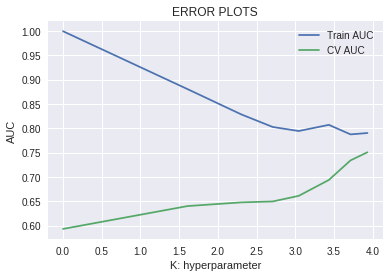

In [0]:

#C = [1, 5, 10, 15, 21, 31, 41, 51]
#from pylab import scatter
#import pylab
#import math
train_auc_kd_bow = []
cv_auc_kd_bow = []
for a in C:
    neigh_kd_bow = KNeighborsClassifier(n_neighbors=a,algorithm='kd_tree')
    model_kd_bow = neigh_kd_bow.fit(X1_train_bow, y1_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y1_train_pred_kd_bow =  model_kd_bow.predict_proba(X1_train_bow)[:,1]
    y1_cv_pred_kd_bow =  model_kd_bow.predict_proba(X1_cv_bow)[:,1]
    train_auc_kd_bow.append(roc_auc_score(y1_train,y1_train_pred_kd_bow))
    cv_auc_kd_bow.append(roc_auc_score(y1_cv, y1_cv_pred_kd_bow))
    

plt.plot(np.log(C), train_auc_kd_bow, label='Train AUC')
plt.plot(np.log(C), cv_auc_kd_bow, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha_kd_bow = C[cv_auc_kd_bow.index(max(cv_auc_kd_bow))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_kd_bow)


The optimal number of cv value in C is 51.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_kd_bow = KNeighborsClassifier(n_neighbors=optimal_alpha_kd_bow)
# fitting the model
knn_optimal_kd_bow.fit(X1_train_bow, y1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')


The auc socre for value= 51.000000 is 0.517444%
[[  46 1002]
 [  50 5502]]
   


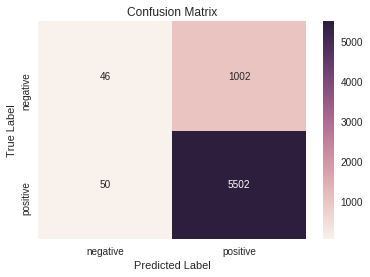

***************************************************************************
[[  86 1369]
 [  58 7465]]
   


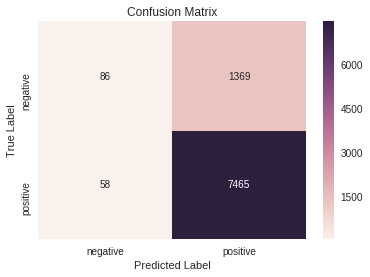

In [0]:
#
pred_kd_bow=knn_optimal_kd_bow.predict(X1_test_bow)
pred_kd_bow_train=knn_optimal_kd_bow.predict(X1_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_kd_bow = roc_auc_score(y1_test, pred_kd_bow)
print('\nThe auc socre for value= %f is %f%%' % (optimal_alpha_kd_bow, auc_kd_bow))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_kd_bow = confusion_matrix(y1_test, pred_kd_bow)
print(cm_kd_bow)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"]
df_kd_bow = pd.DataFrame(cm_kd_bow, index = class_label, columns = class_label)
sns.heatmap(df_kd_bow, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_kd_bow1 = confusion_matrix(y1_train, pred_kd_bow_train)
print(cm_kd_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label1 = ["negative", "positive"]
cm1_kd_bow = pd.DataFrame(cm_kd_bow1, index = class_label, columns = class_label)
sns.heatmap(cm1_kd_bow, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

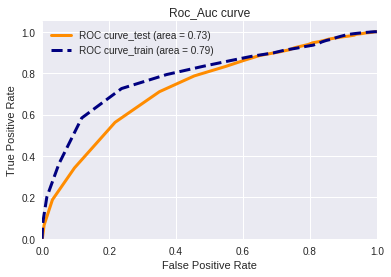

In [0]:

from sklearn import metrics
y1_test_predict =  knn_optimal_kd_bow.predict_proba(X1_test_bow)[:,1]
y1_train_predict =  knn_optimal_kd_bow.predict_proba(X1_train_bow)[:,1]
kd_fpr1,kd_tpr1,_ =  metrics.roc_curve(y1_train,y1_train_predict) 
kd_fpr,kd_tpr, _ = metrics.roc_curve(y1_test,y1_test_predict)

roc_auc_kd = auc(kd_fpr, kd_tpr) 
roc_auc1_kd = auc(kd_fpr1,kd_tpr1) 
### Plot
plt.figure()
#lw = 3
plt.plot(kd_fpr, kd_tpr, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_kd)
plt.plot(kd_fpr1,kd_tpr1, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1_kd)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

##  Tfidf

### Applying KNN using brute on tfidf

In [30]:
tf_idf_vect = TfidfVectorizer()
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
X_train_tfidf

<44890x40977 sparse matrix of type '<class 'numpy.float64'>'
	with 1482378 stored elements in Compressed Sparse Row format>

In [0]:
# Convert test text data to its vectorizor
X_test_tfidf = tf_idf_vect.transform(X_test)
X_cv_tfidf=tf_idf_vect.transform(X_cv)

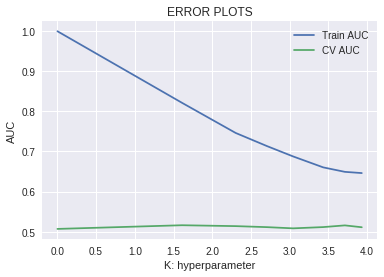

In [32]:

from pylab import scatter
import pylab
import math
train_auc_tfidf = []
cv_auc_tfidf = []
C = [1, 5, 10, 15, 21, 31, 41, 51]
for j in C:
    neigh_tfidf = KNeighborsClassifier(n_neighbors=j,algorithm='brute')
    model_tfidf = neigh_tfidf.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred_tfidf =  model_tfidf.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred_tfidf =  model_tfidf.predict_proba(X_cv_tfidf)[:,1]
    
    
    train_auc_tfidf.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc_tfidf.append(roc_auc_score(y_cv, y_cv_pred_tfidf))
    

plt.plot(list(map(lambda x:math.log(x),C)), train_auc_tfidf, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),C)), cv_auc_tfidf, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [33]:
optimal_alpha_tfidf = C[cv_auc_tfidf.index(max(cv_auc_tfidf))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_tfidf)


The optimal number of cv value in C is 5.000000.


In [34]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_tfidf = KNeighborsClassifier(n_neighbors=optimal_alpha_tfidf)
# fitting the model
knn_optimal_tfidf.fit(X_train_tfidf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
#predicting
pred_tfidf_test1=knn_optimal_tfidf.predict(X_test_tfidf)
pred_tfidf_train1=knn_optimal_tfidf.predict(X_train_tfidf)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_tfidf = roc_auc_score(y_test, pred_tfidf_test1)
print('\nThe auc socre for value= %f is %f%%' % (optimal_alpha_tfidf, auc_tfidf))


The auc socre for value= 5.000000 is 0.501259%


[[  144  5090]
 [  694 27072]]
   


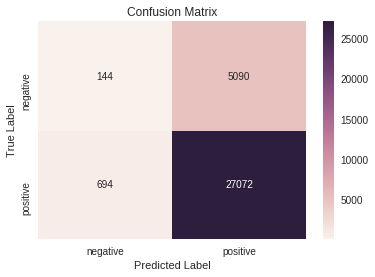

***************************************************************************
[[  861  6147]
 [  475 37407]]
   


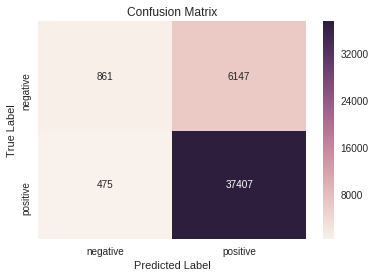

In [36]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_tfidf1 = confusion_matrix(y_test, pred_tfidf_test1)
print(cm_tfidf1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_tfidf1, index = class_label, columns = class_label)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_tfidf2 = confusion_matrix(y_train, pred_tfidf_train1)
print(cm_tfidf2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_cm2 = pd.DataFrame(cm_tfidf2, index = class_label, columns = class_label)
sns.heatmap(df_cm2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

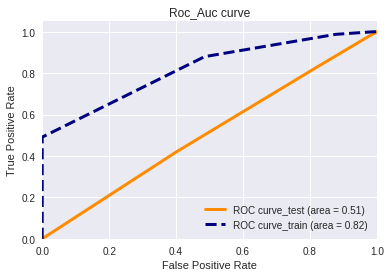

In [37]:
### 
from sklearn import metrics
y_test_predict_tfidf =  knn_optimal_tfidf.predict_proba(X_test_tfidf)[:,1]
y_train_predict_tfidf=  knn_optimal_tfidf.predict_proba(X_train_tfidf)[:,1]
fpr_tfidf,tpr_tfidf,_ =  metrics.roc_curve(y_train,y_train_predict_tfidf) 
fpr_tfidf1,tpr_tfidf1, _ = metrics.roc_curve(y_test,y_test_predict_tfidf)

roc_auc_test_tfidf = auc(fpr_tfidf1, tpr_tfidf1) 
roc_auc_train_tfidf = auc(fpr_tfidf,tpr_tfidf) 
### Plot
plt.figure()
lw = 3 
plt.plot(fpr_tfidf1, tpr_tfidf1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_test_tfidf)
plt.plot(fpr_tfidf,tpr_tfidf , color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_train_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

### Applying using Kdtree

In [0]:
X1_train_tfidf = tf_idf_vect.fit_transform(X1_train)
X1_test_tfidf = tf_idf_vect.transform(X1_test)
X1_cv_tfidf = tf_idf_vect.transform(X1_cv)

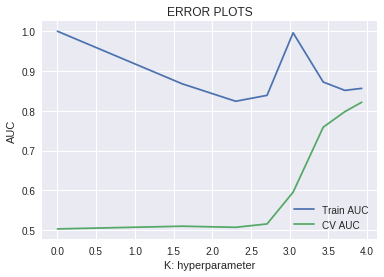

In [39]:

#from pylab import scatter
#import pylab
#import math
train_auc_kd_tfidf = []
cv_auc_kd_tfidf = []
#C = [1, 5, 10, 15, 21, 31, 41, 51]
for b in C:
    neigh_kd_tfidf = KNeighborsClassifier(n_neighbors=b,algorithm='kd_tree')
    model_kd_tfidf = neigh_kd_tfidf.fit(X1_train_tfidf, y1_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y1_train_pred_kd_tfidf =  model_kd_tfidf.predict_proba(X1_train_tfidf)[:,1]
    y1_cv_pred_kd_tfidf =  model_kd_tfidf.predict_proba(X1_cv_tfidf)[:,1]
    
    
    train_auc_kd_tfidf.append(roc_auc_score(y1_train,y1_train_pred_kd_tfidf))
    cv_auc_kd_tfidf.append(roc_auc_score(y1_cv, y1_cv_pred_kd_tfidf))
    

plt.plot(list(map(lambda x:math.log(x),C)), train_auc_kd_tfidf, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),C)), cv_auc_kd_tfidf, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [40]:
optimal_alpha_kd_tfidf = C[cv_auc_kd_tfidf.index(max(cv_auc_kd_tfidf))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_kd_tfidf)


The optimal number of cv value in C is 51.000000.


In [41]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_kd_tfidf = KNeighborsClassifier(n_neighbors=optimal_alpha_kd_tfidf)
# fitting the model
knn_optimal_kd_tfidf.fit(X1_train_tfidf, y1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

In [42]:
pred_kd_tfidf=knn_optimal_kd_tfidf.predict(X1_test_tfidf)
pred_kd_tfidf_train=knn_optimal_kd_tfidf.predict(X1_train_tfidf)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_kd_tfidf = roc_auc_score(y1_test, pred_kd_tfidf)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_kd_tfidf, auc_kd_tfidf))


The Auc socre for value= 51.000000 is 0.500000%


[[   0 1070]
 [   0 5530]]
   


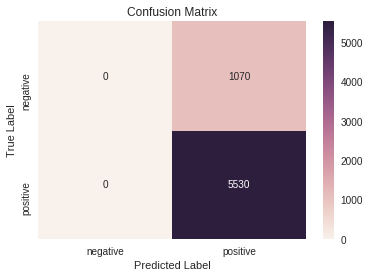

*************************************************************************************************
[[   2 1359]
 [   0 7617]]
   


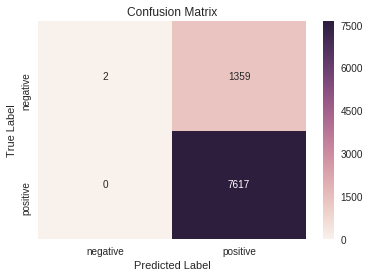

In [43]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_kd_tfidf = confusion_matrix(y1_test, pred_kd_tfidf)
print(cm_kd_tfidf)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_kd_tfidf = pd.DataFrame(cm_kd_tfidf, index = class_label, columns = class_label)
sns.heatmap(df_cm_kd_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_kd_tfidf1 = confusion_matrix(y1_train, pred_kd_tfidf_train)
print(cm_kd_tfidf1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label = ["negative", "positive"]
df_cm1_kd_tfidf = pd.DataFrame(cm_kd_tfidf1, index = class_label, columns = class_label)
sns.heatmap(df_cm1_kd_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

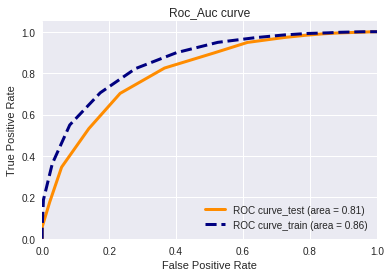

In [44]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y1_test_tfidf_predict =  knn_optimal_kd_tfidf.predict_proba(X1_test_tfidf)[:,1]
y1_train_tfidf_predict =  knn_optimal_kd_tfidf.predict_proba(X1_train_tfidf)[:,1]
kd_fpr_tfidf,kd_tpr_tfidf,_ =  metrics.roc_curve(y1_train,y1_train_tfidf_predict) 
kd_fpr_tfidf_l1,kd_tpr_tfidf_l1, _ = metrics.roc_curve(y1_test,y1_test_tfidf_predict)

roc_auc_kd_tfidf = auc(kd_fpr_tfidf, kd_tpr_tfidf) 
roc_auc1_kd_tfidf = auc(kd_fpr_tfidf_l1,kd_tpr_tfidf_l1) 
### Plot
plt.figure()
#lw = 3
plt.plot(kd_fpr_tfidf_l1, kd_tpr_tfidf_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc1_kd_tfidf)
plt.plot(kd_fpr_tfidf,kd_tpr_tfidf, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_kd_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## W2V

In [0]:
#W2V

import re
import string
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned 
# Removing the Punctuations and HTML Tags too

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [46]:
import gensim
i=0
sent_of_train=[]
for sentance in X_train:
    sent_of_train.append(sentance.split())
w2v_model=gensim.models.Word2Vec(sent_of_train,min_count=5,size=200, workers=4)    
print(type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
## for kd_tree
print('##'*20)
sent_of_train1=[]
for sentance1 in X1_train:
  sent_of_train1.append(sentance1.split())
w2v_model1=gensim.models.Word2Vec(sent_of_train1,min_count=5,size=200, workers=4)    
print(type(w2v_model1))
w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

<class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  13040
sample words  ['great', 'coffee', 'especially', 'like', 'bold', 'flavor', 'use', 'product', 'satisfied', 'completely', 'missed', 'blend', 'note', 'thinking', 'coconut', 'flour', 'sure', 'many', 'people', 'looking', 'gluten', 'free', 'part', 'lower', 'carb', 'non', 'grain', 'primal', 'diet', 'not', 'work', 'rice', 'potato', 'starch', 'city', 'bread', 'love', 'keep', 'stored', 'freezer', 'take', 'needed', 'thaw', 'microwave', 'toast', 'purchase', 'thru', 'amazon', 'since', 'price']
########################################
<class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  5660
sample words  ['mini', 'marshmallows', 'impossible', 'find', 'anywhere', 'else', 'perfect', 'addition', 'hot', 'chocolate', 'basket', 'made', 'niece', 'nephew', 'christmas', 'received', 'quickly', 'no', 'problems', 'excellent', 'ways', 'old', 'dog', 'likes', 'much', 'bought', 'seem', 'g

In [0]:

# List of sentence in X_test text
sent_of_test=[]
for sent1 in X_test:
    sent_of_test.append(sent1.split())   
#List of sentences in X_cv
sent_of_cv=[]
for sent2 in X_cv:
    sent_of_cv.append(sent2.split())
#####################################################################
# List of sentence in X1_test text
sent_of_test1=[]
for sent11 in X1_test:
    sent_of_test1.append(sent11.split())   
#List of sentences in X1_cv
sent_of_cv1=[]
for sent21 in X1_cv:
    sent_of_cv1.append(sent21.split())

# AVG W2V

In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent1 in sent_of_train:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word1 in sent1: # 
        if word1 in w2v_words:
            vec = w2v_model.wv[word1]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent11 in sent_of_test:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word11 in sent11: # 
        if word11 in w2v_words:
            vec = w2v_model.wv[word11]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 
    
# compute average word2vec for each review for X_cv .
cv_vectors = []; 
for sent111 in sent_of_cv:
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word111 in sent111: # 
        if word111 in w2v_words:
            vec = w2v_model.wv[word111]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec) 

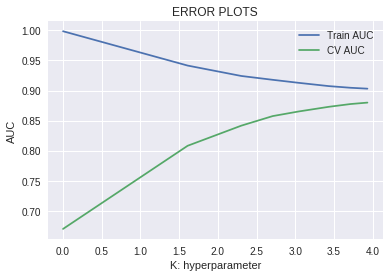

In [49]:
#C=[] 
train_avg_l1 = []
cv_avg_l1= []
for k in C:
    neigh_avg_l1 = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    model_avg_l1 = neigh_avg_l1.fit(train_vectors, y_train)
    y_train_predavg_l1 =  model_avg_l1.predict_proba(train_vectors)[:,1]
    y_cv_predavg_l1 =  model_avg_l1.predict_proba(cv_vectors)[:,1]
    train_avg_l1.append(roc_auc_score(y_train,y_train_predavg_l1))
    cv_avg_l1.append(roc_auc_score(y_cv, y_cv_predavg_l1))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_avg_l1, label='Train AUC')
plt.plot(np.log(C), cv_avg_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [50]:
optimal_alpha_w2v_cv = C[cv_avg_l1.index(max(cv_avg_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_w2v_cv)


The optimal number of cv value in C is 51.000000.


In [51]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_w2v_l1 =KNeighborsClassifier(n_neighbors=optimal_alpha_w2v_cv)
knn_optimal_w2v_l1.fit(train_vectors, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

In [52]:
pred_w2v_l1=knn_optimal_w2v_l1.predict(test_vectors)
pred_w2v_train_l1=knn_optimal_w2v_l1.predict(train_vectors)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_w2v_l1 = roc_auc_score(y_test, pred_w2v_l1)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_w2v_cv, auc_w2v_l1))


The Auc socre for value= 51.000000 is 0.613272%


[[ 1247  3987]
 [  325 27441]]
   


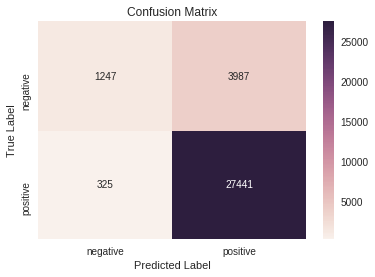

*************************************************************************************************
[[ 1813  5195]
 [  427 37455]]
   


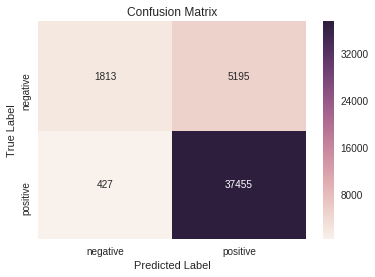

In [53]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg = confusion_matrix(y_test, pred_w2v_l1)
print(cm_avg)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm_w2v = pd.DataFrame(cm_avg, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_avg1 = confusion_matrix(y_train, pred_w2v_train_l1)
print(cm_avg1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_cm1_w2v = pd.DataFrame(cm_avg1, index = class_label, columns = class_label)
sns.heatmap(df_cm1_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

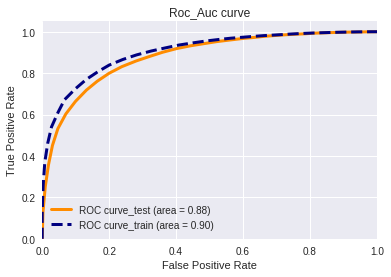

In [54]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_w2v_predict =  knn_optimal_w2v_l1.predict_proba(test_vectors)[:,1]
y_train_w2v_predict =  knn_optimal_w2v_l1.predict_proba(train_vectors)[:,1]
fpr,tpr,_ =  metrics.roc_curve(y_train,y_train_w2v_predict) 
fpr_l1,tpr_l1, _ = metrics.roc_curve(y_test,y_test_w2v_predict)

roc_auc = auc(fpr_l1, tpr_l1) 
roc_auc1 = auc(fpr,tpr) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr_l1, tpr_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot( fpr,tpr, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## Appplying KNN on AVG w2v using kdtree

In [0]:
# compute average word2vec for each review for X1_train .
train_vectors1 = []; 
for sent in sent_of_train1:
    sent_vec1 = np.zeros(200) 
    cnt_words1 =0; 
    for word11 in sent: # 
        if word11 in w2v_words1:
            vec1 = w2v_model1.wv[word11]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    train_vectors1.append(sent_vec1)
    
# compute average word2vec for each review for X1_test .
test_vectors1 = []; 
for sent111 in sent_of_test1:
    sent_vec1 = np.zeros(200) 
    cnt_words1 =0; 
    for word111 in sent111: # 
        if word111 in w2v_words1:
            vec1 = w2v_model1.wv[word11]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    test_vectors1.append(sent_vec1) 
    
# compute average word2vec for each review for X1_cv .
cv_vectors1 = []; 
for sent112 in sent_of_cv1:
    sent_vec1 = np.zeros(200) 
    cnt_words1 =0; 
    for word111 in sent112: # 
        if word111 in w2v_words1:
            vec1 = w2v_model1.wv[word111]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    cv_vectors1.append(sent_vec1) 

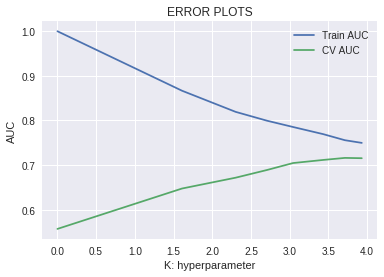

In [56]:


train_avg_l2 = []
cv_avg_l2= []
for a in C:
    neigh_avg_l2 = KNeighborsClassifier(n_neighbors=a,algorithm='kd_tree')
    model_avg_l2 = neigh_avg_l2.fit(train_vectors1, y1_train)
    y_train_predavg_l2 =  model_avg_l2.predict_proba(train_vectors1)[:,1]
    y_cv_predavg_l2 =  model_avg_l2.predict_proba(cv_vectors1)[:,1]
    train_avg_l2.append(roc_auc_score(y1_train,y_train_predavg_l2))
    cv_avg_l2.append(roc_auc_score(y1_cv, y_cv_predavg_l2))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_avg_l2, label='Train AUC')
plt.plot(np.log(C), cv_avg_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [57]:
optimal_alpha_w2v1_cv = C[cv_avg_l2.index(max(cv_avg_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_w2v1_cv)


The optimal number of cv value in C is 41.000000.


In [58]:
# instantiate learning model alpha = optimal_alpha
knn_optimal_w2v_l2 = KNeighborsClassifier(n_neighbors= optimal_alpha_w2v1_cv)
# fitting the model
knn_optimal_w2v_l2.fit(train_vectors1, y1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=41, p=2,
           weights='uniform')

In [59]:
pred_w2v_l2=knn_optimal_w2v_l2.predict(test_vectors1)
pred_w2v_train_l2=knn_optimal_w2v_l2.predict(train_vectors1)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_w2v_l2 = roc_auc_score(y1_test, pred_w2v_l2)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_w2v1_cv, auc_w2v_l2))


The Auc socre for value= 41.000000 is 0.500000%


[[   0 1070]
 [   0 5530]]
   


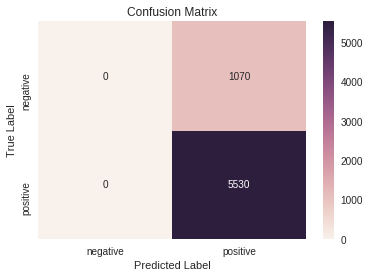

*************************************************************************************************
[[  22 1339]
 [   6 7611]]
   


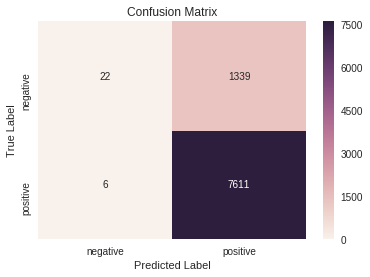

In [60]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_avg11 = confusion_matrix(y1_test, pred_w2v_l2)
print(cm_avg11)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2v11 = pd.DataFrame(cm_avg11, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2v11, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_avg2 = confusion_matrix(y1_train, pred_w2v_train_l2)
print(cm_avg2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_cm1_w2v2 = pd.DataFrame(cm_avg2, index = class_label, columns = class_label)
sns.heatmap(df_cm1_w2v2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

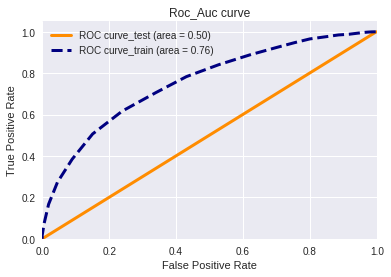

In [62]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y1_test_w2v_predict1 =  knn_optimal_w2v_l2.predict_proba(test_vectors1)[:,1]
y1_train_w2v_predict1 =  knn_optimal_w2v_l2.predict_proba(train_vectors1)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y1_train,y1_train_w2v_predict1) 
fpr_l2,tpr_l2, _ = metrics.roc_curve(y1_test,y1_test_w2v_predict1)

roc_auc11 = auc(fpr_l2, tpr_l2) 
roc_aucl2 = auc(fpr1,tpr1) 
### Plot
plt.figure()
#lw = 3
plt.plot(fpr_l2, tpr_l2, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc11)
plt.plot( fpr1,tpr1,color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_aucl2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## TF_IDF W2v

In [63]:
# TF-IDF weighted Word2Vec
tfidf_vectorizer = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
final_tfidf_test = tfidf_vectorizer.transform(X_test)
final_tfidf_cv = tfidf_vectorizer.transform(X_cv)
dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))

# tfidf words/col-names
tfidf_features = tfidf_vectorizer.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for senttrain in tqdm(sent_of_train): 
    sent_vec_train = np.zeros(200)
    weight_sum_train =0; 
    for word_train in senttrain: 
        if word_train in w2v_words and word_train in tfidf_features:
            vec_1 = w2v_model.wv[word_train]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_train = final_tfidf_train[row, tfidf_features.index(word_train)]
            tfidf_train = dictionary[word_train]*(senttrain.count(word_train)/len(senttrain))
            sent_vec_train += (vec_1 * tfidf_train)
            weight_sum_train += tfidf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_train_vectors.append(sent_vec_train)
    row += 1

100%|██████████| 44890/44890 [15:35<00:00, 45.20it/s]


In [64]:
# compute TFIDF Weighted Word2Vec for each review for X_cv .
tfidf_cv_vectors = []; 
#row=0;
for sentcv in tqdm(sent_of_cv): 
    sent_vec_cv = np.zeros(200) 
    weight_sum_cv =0; 
    for word_cv in sentcv: 
        if word_cv in w2v_words and word_cv in tfidf_features:
            vec_2 = w2v_model.wv[word_cv]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_cv = final_tfidf_cv[row, tfidf_features.index(word)]
            tfidf_cv = dictionary[word_cv]*(sentcv.count(word_cv)/len(sentcv))
            sent_vec_cv += (vec_2 * tfidf_cv)
            weight_sum_cv += tfidf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_cv_vectors.append(sent_vec_cv)
    row += 1

100%|██████████| 22110/22110 [07:33<00:00, 48.72it/s]


In [65]:
# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
#row=0;
for senttest in tqdm(sent_of_test): 
    sent_vec_test = np.zeros(200) 
    weight_sum_test =0; 
    for word_test in senttest: 
        if word_test in w2v_words and word_test in tfidf_features:
            vec_3 = w2v_model.wv[word_test]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_test = final_tfidf_test[row, tfidf_features.index(word)]
            tfidf_test = dictionary[word_test]*(senttest.count(word_test)/len(senttest))
            sent_vec_test += (vec_3 * tfidf_test)
            weight_sum_test += tfidf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_test_vectors.append(sent_vec_test)
    row += 1

100%|██████████| 33000/33000 [11:24<00:00, 48.19it/s]


## KNN using brute

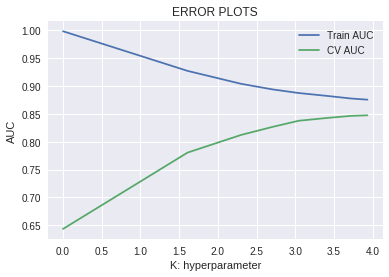

In [66]:

train_w2v_l1 = []
cv_w2v_l1= []
for b in C:
    neigh_w2v_l1 = KNeighborsClassifier(n_neighbors=b,algorithm='kd_tree')
    model_w2v_l1 = neigh_w2v_l1.fit(tfidf_train_vectors, y_train)
    y_train_predw2v_l1 =  model_w2v_l1.predict_proba(tfidf_train_vectors)[:,1]
    y_cv_predw2v_l1 =  model_w2v_l1.predict_proba(tfidf_cv_vectors)[:,1]
    train_w2v_l1.append(roc_auc_score(y_train,y_train_predw2v_l1))
    cv_w2v_l1.append(roc_auc_score(y_cv, y_cv_predw2v_l1))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_w2v_l1, label='Train AUC')
plt.plot(np.log(C), cv_w2v_l1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [67]:
optimal_alpha_tfw2v_cv = C[cv_w2v_l1.index(max(cv_w2v_l1))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_tfw2v_cv)


The optimal number of cv value in C is 51.000000.


In [68]:
# instantiate learning model alpha = optimal_alpha
optimal_w2v_l1 = KNeighborsClassifier(n_neighbors=optimal_alpha_tfw2v_cv)
# fitting the model
optimal_w2v_l1.fit(tfidf_train_vectors, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

In [69]:
pred_tfw2v_l1=optimal_w2v_l1.predict(tfidf_test_vectors)#test
pred_tfw2v_train_l1=optimal_w2v_l1.predict(tfidf_train_vectors)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_of_l1 = roc_auc_score(y_test, pred_tfw2v_l1)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_tfw2v_cv, auc_of_l1))


The Auc socre for value= 51.000000 is 0.584535%


[[  936  4298]
 [  271 27495]]
   


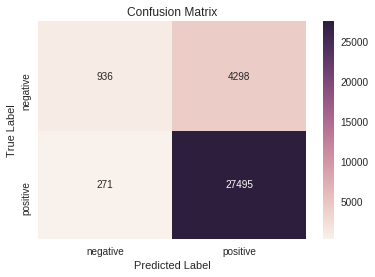

*************************************************************************************************
[[ 1332  5676]
 [  334 37548]]
   


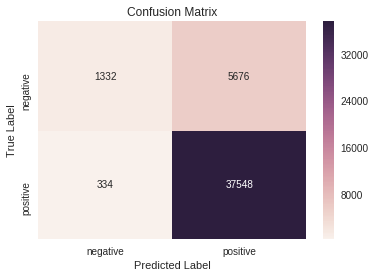

In [70]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_w2v = confusion_matrix(y_test, pred_tfw2v_l1)
print(cm_w2v)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_conf_w2v = pd.DataFrame(cm_w2v, index = class_label, columns = class_label)
sns.heatmap(df_conf_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_w2v1 = confusion_matrix(y_train, pred_tfw2v_train_l1)
print(cm_w2v1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
#class_label1 = ["negative", "positive"]
df_conf1_w2v = pd.DataFrame(cm_w2v1, index = class_label, columns = class_label)
sns.heatmap(df_conf1_w2v, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

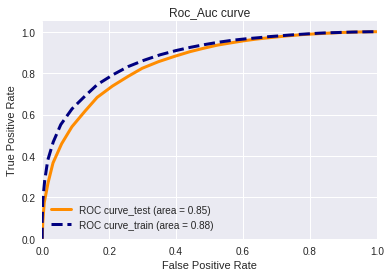

In [71]:
### Computing ROC curve and ROC area for predictions on l1 validation set
from sklearn import metrics
y_test_tfw2v_predict = optimal_w2v_l1.predict_proba(tfidf_test_vectors)[:,1]
y_train_tfw2v_predict = optimal_w2v_l1.predict_proba(tfidf_train_vectors)[:,1]
fpr,tpr,_ =  metrics.roc_curve(y_train,y_train_tfw2v_predict) 
fpr_l1,tpr_l1, _ = metrics.roc_curve(y_test,y_test_tfw2v_predict)

roc_auc = auc(fpr_l1, tpr_l1) 
roc_auc1 = auc(fpr,tpr) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr_l1, tpr_l1, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot( fpr,tpr, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

## Applying KNN using kd_tree

In [72]:
# TF-IDF weighted Word2Vec
#tfidf_vectorizer = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tfidf_train1 = tfidf_vectorizer.fit_transform(X1_train)
final_tfidf_test1 = tfidf_vectorizer.transform(X1_test)
final_tfidf_cv1 = tfidf_vectorizer.transform(X1_cv)
#dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))

# tfidf words/col-names
#tfidf_features = tfidf_vectorizer.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X1_train .
tfidf_train_vectors1 = []; 
row=0;
for senttrain1 in tqdm(sent_of_train1): 
    sent_vec_train1 = np.zeros(200)
    weight_sum_train1 =0; 
    for word_train1 in senttrain1: 
        if word_train1 in w2v_words1 and word_train1 in tfidf_features:
            vec_11 = w2v_model1.wv[word_train1]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_train = final_tfidf_train[row, tfidf_features.index(word_train)]
            tfidf_train1 = dictionary[word_train1]*(senttrain1.count(word_train1)/len(senttrain1))
            sent_vec_train1 += (vec_11 * tfidf_train1)
            weight_sum_train1 += tfidf_train1
    if weight_sum_train1 != 0:
        sent_vec_train1 /= weight_sum_train1
    tfidf_train_vectors1.append(sent_vec_train1)
    row += 1

100%|██████████| 8978/8978 [02:56<00:00, 50.97it/s]


In [73]:
# compute TFIDF Weighted Word2Vec for each review for X1_cv .
tfidf_cv_vectors1 = []; 
#row=0;
for sentcv1 in tqdm(sent_of_cv1): 
    sent_vec_cv1 = np.zeros(200) 
    weight_sum_cv1 =0; 
    for word_cv1 in sentcv1: 
        if word_cv1 in w2v_words1 and word_cv1 in tfidf_features:
            vec_21 = w2v_model1.wv[word_cv1]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_cv = final_tfidf_cv[row, tfidf_features.index(word)]
            tfidf_cv1 = dictionary[word_cv1]*(sentcv1.count(word_cv1)/len(sentcv1))
            sent_vec_cv1 += (vec_21 * tfidf_cv1)
            weight_sum_cv1 += tfidf_cv1
    if weight_sum_cv1 != 0:
        sent_vec_cv1 /= weight_sum_cv1
    tfidf_cv_vectors1.append(sent_vec_cv1)
    row += 1

100%|██████████| 4422/4422 [01:27<00:00, 50.31it/s]


In [74]:
# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors1 = []; 
#row=0;
for senttest1 in tqdm(sent_of_test1): 
    sent_vec_test1 = np.zeros(200) 
    weight_sum_test1 =0; 
    for word_test1 in senttest1: 
        if word_test1 in w2v_words1 and word_test1 in tfidf_features:
            vec_31 = w2v_model1.wv[word_test1]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_test = final_tfidf_test[row, tfidf_features.index(word)]
            tfidf_test1 = dictionary[word_test1]*(senttest1.count(word_test1)/len(senttest1))
            sent_vec_test1 += (vec_31 * tfidf_test1)
            weight_sum_test1 += tfidf_test1
    if weight_sum_test1 != 0:
        sent_vec_test1 /= weight_sum_test
    tfidf_test_vectors1.append(sent_vec_test1)
    row += 1

100%|██████████| 6600/6600 [02:10<00:00, 50.59it/s]


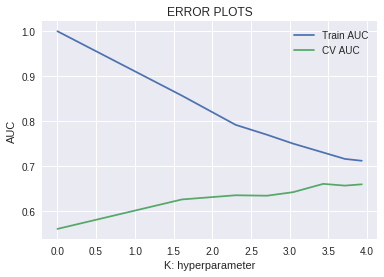

In [75]:

train_w2v_l2 = []
cv_w2v_l2= []
for t in C:
    neigh_w2v_l2 = KNeighborsClassifier(n_neighbors=t,algorithm='kd_tree')
    model_w2v_l2 = neigh_w2v_l2.fit(tfidf_train_vectors1, y1_train)
    y_train_predw2v_l2 =  model_w2v_l2.predict_proba(tfidf_train_vectors1)[:,1]
    y_cv_predw2v_l2 =  model_w2v_l2.predict_proba(tfidf_cv_vectors1)[:,1]
    train_w2v_l2.append(roc_auc_score(y1_train,y_train_predw2v_l2))
    cv_w2v_l2.append(roc_auc_score(y1_cv, y_cv_predw2v_l2))
    
#plt.plot(C,train_auc_tfidf_l1,label='Train AUC')
#plt.plot(C,cv_auc_tfidf_l1, label='CV AUC')
plt.plot(np.log(C), train_w2v_l2, label='Train AUC')
plt.plot(np.log(C), cv_w2v_l2, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [76]:
optimal_alpha_cv = C[cv_w2v_l2.index(max(cv_w2v_l2))]
print('\nThe optimal number of cv value in C is %f.' % optimal_alpha_cv)


The optimal number of cv value in C is 31.000000.


In [77]:
# instantiate learning model alpha = optimal_alpha
optimal_w2v_l2 = KNeighborsClassifier(n_neighbors=optimal_alpha_cv)
# fitting the model
optimal_w2v_l2.fit(tfidf_train_vectors1, y1_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=31, p=2,
           weights='uniform')

In [78]:
pred_tfw2v_l2=optimal_w2v_l2.predict(tfidf_test_vectors1) #test
pred_tfw2v_train_l2=optimal_w2v_l2.predict(tfidf_train_vectors1)
# evaluate accuracy on test data
#from sklearn.metrics import roc_auc_score
auc_tfw2v_l2 = roc_auc_score(y1_test, pred_tfw2v_l2)
print('\nThe Auc socre for value= %f is %f%%' % (optimal_alpha_cv, auc_tfw2v_l2))


The Auc socre for value= 31.000000 is 0.504990%


[[  13 1057]
 [  12 5518]]
   


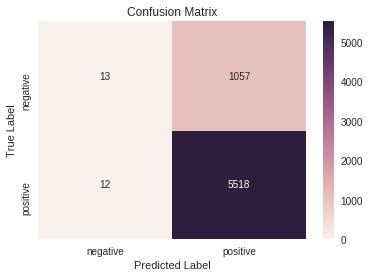

*************************************************************************************************
[[  15 1346]
 [   5 7612]]
   


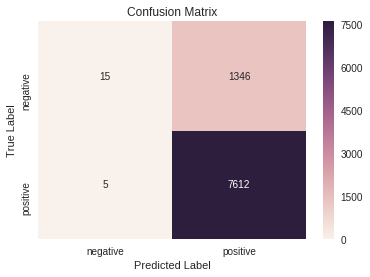

In [79]:
# Confusion Matrix
#from sklearn.metrics import confusion_matrix
cm_l2 = confusion_matrix(y1_test, pred_tfw2v_l2)
print(cm_l2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2vl2 = pd.DataFrame(cm_l2, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2vl2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('*************************************************************************************************')

cm_w2vl2 = confusion_matrix(y1_train, pred_tfw2v_train_l2)
print(cm_w2vl2)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
#import seaborn as sns
#class_label = ["negative", "positive"]
df_cm_w2vl2 = pd.DataFrame(cm_w2vl2, index = class_label, columns = class_label)
sns.heatmap(df_cm_w2vl2, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

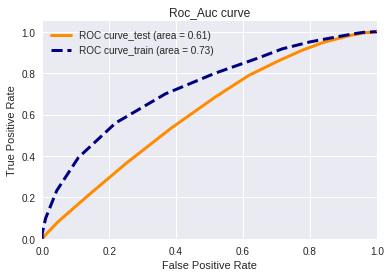

In [80]:
### Computing ROC curve and ROC area for predictions on l1 validation set
#from sklearn import metrics
y_test_w2v_predictl2 =  optimal_w2v_l2.predict_proba(tfidf_test_vectors1)[:,1]
y_train_w2v_predictl2 =  optimal_w2v_l2.predict_proba(tfidf_train_vectors1)[:,1]
train_fpr,train_tpr,_ =  metrics.roc_curve(y1_train,y_train_w2v_predictl2) 
fpr_l2,tpr_l2, _ = metrics.roc_curve(y1_test,y_test_w2v_predictl2)

roc_auc_test_l2 = auc(fpr_l2, tpr_l2) 
roc_auc_train_l2 = auc(train_fpr,train_tpr) 
### Plot
plt.figure()
#lw = 3
plt.plot(fpr_l2, tpr_l2, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_test_l2)
plt.plot( train_fpr,train_tpr,color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc_train_l2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

### Conclussion :-

- From Above KNN project.,You have to observe that.,<br> I have taken 100000 points to train using brute and <br> i have taken 20000 points using kd_tree., <br> For all two above algorithms i have showed three metrics called<br>1. plotting curve using train and cv <br> 2. Confusion matrix <br> 3. plotting curve (ROC_AUC curve) using Train and test for true positve and false positive rate..